In [906]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn/models')

#from models.multilevel_layers import MultilevelDense

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from functools import reduce
import ipdb


tfd = tfp.distributions

In [2]:
%load_ext tensorboard

In [11]:
def data_generator(gid):
    #x_tf = tf.cast(tf.convert_to_tensor(gid), tf.int32)
    gid_tf = tf.cast(tf.convert_to_tensor(gid), tf.int32)
    num_groups = tf.cast(tf.convert_to_tensor(max(gid) + 1), tf.int32)
    """Creates a joint distribution for the varying slope model."""
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=1., scale=0.1, name='w_z_0'),
#         tfd.Independent(
#             tfd.HalfCauchy(loc=tf.ones([num_groups])*0.1, scale=0.01, name='w_lambda_k'),
#             reinterpreted_batch_ndims=1),
        tfd.HalfCauchy(loc=1, scale=0.01, name='w_lambda_k'),

        lambda w_lambda_k, w_z_0: tfd.Independent(tfd.Normal( 
            loc=tf.ones([num_groups])*w_z_0,
            scale=w_lambda_k,
            name='w_z_k'), reinterpreted_batch_ndims=1),

        lambda w_z_k: tfd.MultivariateNormalDiag(  # y
            loc=tf.gather(w_z_k, gid_tf, axis=-1) ,
            scale_identity_multiplier=0.5,
            name='x')
   ])

In [12]:
ng=3
avg_samp = 30
np.random.seed(35)
gi = np.random.choice(ng, size=[ng*avg_samp])

In [13]:
import collections
collections.Counter(gi)

Counter({1: 28, 0: 36, 2: 26})

In [14]:
gen_process = data_generator(gi)

In [15]:
tf.random.set_seed(4)
gen = gen_process.sample(seed=7)

In [16]:
xi=gen[-1].numpy()
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9806732>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0385405>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.16555518, 0.99236894, 2.2233448 ], dtype=float32)>]

In [558]:
yi = 2.*xi + 1. + np.random.randn(len(xi))/5

In [599]:
x_train, x_test, y_train, y_test,  gid_train, gid_test = train_test_split(
    xi, yi, gi, stratify=gi, random_state=9, test_size=0.9)
tts = [x_train, x_test, y_train, y_test, gid_train, gid_test]

x_train = tf.convert_to_tensor(x_train)[...,tf.newaxis]
x_test = tf.convert_to_tensor(x_test)[...,tf.newaxis]
y_train = tf.convert_to_tensor(y_train)[...,tf.newaxis]
y_test = tf.convert_to_tensor(y_test)[...,tf.newaxis]
gid_train = tf.cast(tf.convert_to_tensor(gid_train), tf.int32)
gid_test = tf.cast(tf.convert_to_tensor(gid_test), tf.int32)

## Baseline model

In [600]:
def mean_estimator_error(train, test):
    return np.abs(np.mean(train) - np.mean(test))
    

In [611]:
check_tensor = lambda x: isinstance(x, tf.python.framework.ops.EagerTensor)

In [612]:
def get_segments(data, gid, idx): 
    if check_tensor(data):
        data = data.numpy()
    if check_tensor(gid):
        gid = gid.numpy()
    return data[np.where(gid == idx)[0]]

In [613]:
print('Baseline estimator:', mean_estimator_error(x_train, x_test))

Baseline estimator: 0.263757


In [615]:
for i in range(ng):
    train = get_segments(x_train, gid_train, i)
    test = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train, test))

Baseline estimator per group: 0.1178029
Baseline estimator per group: 0.21350116
Baseline estimator per group: 0.5193312


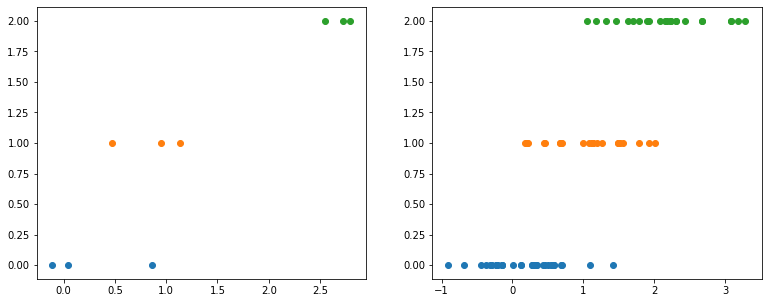

In [616]:
fig, axes =plt.subplots(1,2, figsize=(13,5))
for i in range(ng):
    
    axes[0].scatter(get_segments(x_train, gid_train, i), [i]*len(get_segments(x_train, gid_train, i)))

    axes[1].scatter(get_segments(x_test, gid_test, i), [i]*len(get_segments(x_test, gid_test, i)))

In [617]:
gen[2]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.16555518, 0.99236894, 2.2233448 ], dtype=float32)>

## Model classes

In [1117]:
class HierarchicalVariableLayer(tf.keras.layers.Layer):
    
    def __init__(self, variable_shape, num_groups, kl_weight,
                 #prior_kl_weight, group_kl_weights, 
                 **kwargs):
        super(HierarchicalVariableLayer, self).__init__(**kwargs)
        self.variable_shape = variable_shape
        # flatten out input into a vector
        if isinstance(variable_shape, list) or isinstance(variable_shape, tuple):
            self.units = reduce(lambda x, y: x*y, variable_shape)
        else:
            self.units = variable_shape
        #    self.units = int(variable_shape)
        
        self.num_groups = num_groups

#         self.prior_kl_weight = prior_kl_weight
#         self.group_kl_weights = group_kl_weights
        self.kl_weight = kl_weight

        
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2),
#             tf.keras.layers.InputSpec(ndim=1)]
        
    def build(self, input_shape):
        
        # TODO: do something diff for only 1?
#         x_input_shape, gid_input_shape = input_shape
#         last_dim = x_input_shape[-1]
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2, axes={-1: last_dim}),
#             tf.keras.layers.InputSpec(ndim=1)]
        
        
        # Mean of the variational posterior for group latents
        self.mu_k = self.add_weight(
            shape=(self.num_groups, self.units),
            initializer='random_normal', name='mu_k')
        # Variance of the variational posterior for group latents
        self.sigma_k = self.add_weight(
            shape=(self.num_groups, self.units),
            initializer=tf.constant_initializer(-4.), name='sigma_k')

        # Mean of the variational posterior for group prior z_0 
        self.mu0 = self.add_weight(
            shape=(self.units,),
            initializer='ones', name='mu0')
        # Variance of the variational posterior for the group mean z_0
        self.sigma0 = self.add_weight(
            shape=(self.units,),
            initializer=tf.constant_initializer(-4.), name='sigma0')
        
        # Fixed parameters for hyperprior over z_0 ~ N(0, v^-1)
        self.z0_prior_mean = tf.Variable(0., trainable=False, name='z0_prior_mean')
        self.z0_prior_variance = tf.Variable(100., trainable=False, name='z0_prior_variance')

        # Mean of the variational posterior for group prior variance tau_k 
        self.tau_k_mu = self.add_weight(
            shape=(self.num_groups, self.units),
            initializer=tf.constant_initializer(-1), name='tau_k_mu')
        # Variance of the variational posterior for the group prior variance tau_k
        self.tau_k_sigma = self.add_weight(
            shape=(self.num_groups, self.units),
            initializer=tf.constant_initializer(-2), name='tau_k_sigma')
        
        # Fixed parameters for hyperprior over tau_k ~ N(0, tau_0)
        self.tau_k_prior_mean = tf.Variable(0., trainable=False, name='tau_k_prior_mean')
        # Fixed hyperprior over tau_k, aka tau_0
        self.tau_k_prior_variance = tf.Variable(100., trainable=False, name='tau_k_prior_variance')
        
        super(HierarchicalVariableLayer, self).build(input_shape)
        
    
    @tf.function
    def sample_posterior(self, mu, sigma):
        # By sampling after gather, I use different noise for each sample
        eps = np.random.randn(*mu.shape)
        samp = mu + sigma*eps
        return samp

    @tf.function
    def compute_kl(self, mu1, sigma1, mu2, sigma2):
        kl = (
            tf.math.log(sigma2/sigma1)
            + (sigma1**2 + (mu1-mu2)**2)/(2*sigma2**2)
            - 0.5)
        return kl
    
         
    @tf.function
    def call(self, gid):

        #assert len(gid.shape) == 1, "gid should be flat vector!"
        
        var_activation = tf.math.exp
        sigma_k_pos = var_activation(self.sigma_k)
        sigma0_pos = var_activation(self.sigma0)
        tau_k_sigma_pos = var_activation(self.tau_k_sigma)
        
        
        # KL between var post on z0 and fixed prior over z0        
        z0_kl_loss_fn = lambda: tf.multiply(
            self.kl_weight,
            tf.reduce_sum(self.compute_kl(
                self.mu0, 
                # Changed from sigma0_pos to this to make it work...
                var_activation(self.sigma0),
                self.z0_prior_mean, self.z0_prior_variance)))

        tau_k_kl_loss_fn = lambda: tf.reduce_sum(
            tf.multiply(
            self.kl_weight,
            self.compute_kl(
                self.tau_k_mu, var_activation(self.tau_k_sigma),
                self.tau_k_prior_mean, self.tau_k_prior_variance)))

        def z_k_kl_loss_fn(): 
            sigma_k_pos = var_activation(self.sigma_k)
            tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
            tau_k_sq = tau_k ** 2 
            z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))
            kl = self.compute_kl(self.mu_k, sigma_k_pos, z0, tau_k_sq)
        
            return tf.multiply(self.kl_weight, tf.reduce_sum(kl))
        
#         def z_k_kl_loss_fn():
#             sigma_k_pos = var_activation(self.sigma_k)
#             tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
#             tau_k_sq = tau_k ** 2 
#             sigma0_pos = var_activation(self.sigma0)
#             #z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))
            
#             d = self.units
#             z_k_log_prob = (
#                 - 1/2 * d * np.log(2*np.pi) 
#                 - 1/2 * d * tf.math.log(tau_k_sq)
#                 - 1/2/tau_k_sq * (
#                     tf.reduce_sum(sigma_k_pos, axis=[-1]) 
#                     + tf.reduce_sum(sigma0_pos, axis=[-1]) 
#                     + tf.einsum('Bi, Bi -> ', self.mu_k, self.mu_k)
#                     + tf.einsum('i, i -> ', self.mu0, self.mu0)
#                     - 2 * tf.einsum('Bi, i -> ', self.mu_k, self.mu0)))
            
#             return -1 * tf.multiply(self.kl_weight, tf.reduce_sum(z_k_log_prob))

        
        # Can access using model.metrics later once I do custom training
        self.add_metric(z0_kl_loss_fn(), name='z0_kl_loss', aggregation='mean')
        #self.add_metric(tau_k_kl_loss_fn(), name='tau_k_kl_loss', aggregation='mean')
        self.add_metric(z_k_kl_loss_fn(), name='z_k_kl_loss', aggregation='mean')
        
        #self.add_loss(lambda: tf.reduce_sum(var_activation(self.sigma0)) )
        self.add_loss(z0_kl_loss_fn)
        #self.add_loss(tau_k_kl_loss_fn)
        self.add_loss(z_k_kl_loss_fn)
        
        gather = lambda x: tf.gather(x, gid)
        z = self.sample_posterior(gather(self.mu_k), gather(sigma_k_pos))
        var = tf.reshape(z, [-1, *self.variable_shape])
        
        return var
    

In [1118]:
@tf.function
def tf_gather(x, ind):
    return tf.gather(x + 0, ind)

In [1119]:
# group_kl_weights should be [k1, k2, k3] / train_size

## Single parameter

In [1120]:
var = HierarchicalVariableLayer((50,200), 30, 1.)

In [1121]:
from collections import Counter

In [1122]:
batch_size=9
num_batches = np.ceil(len(x_train) / batch_size)
count_dict = Counter(gid_train.numpy())
group_train_sizes = np.array([count_dict[i] for i in range(ng)])
# I think this is actually not correct
#group_kl_weights = group_train_sizes / num_batches

In [1123]:
print(num_batches)
print(1/num_batches)
#print(group_kl_weights)

1.0
1.0


In [1202]:
gid = Input(shape=[1], dtype=tf.int32, batch_size=batch_size)
x_hier = HierarchicalVariableLayer(
    variable_shape=(1,), 
    num_groups=tf.convert_to_tensor(ng),
    # Make sure this prior weight stays updated
#     prior_kl_weight=tf.convert_to_tensor(num_batches, dtype=tf.float32),
#     group_kl_weights=tf.convert_to_tensor(group_kl_weights, dtype=tf.float32))
    kl_weight=tf.convert_to_tensor(1/num_batches, dtype=tf.float32))
out = x_hier(gid)
model = Model(
    inputs=gid, 
    outputs=out)

In [1203]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss='mean_squared_error',
    metrics=['mse'])

In [1204]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model.fit(x=gid_train, 
          y=x_train, 
          batch_size=len(x_train), 
          epochs=100, 
          #verbose=False,
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../experiments/parameter_est/' + current_time, 
                                                    profile_batch='5',
                                                    histogram_freq=10)])

Epoch 1/100
1/1 [==============================] - 0s 7ms/step - loss: 43.3069 - mse: 2.6679 - z0_kl_loss: 8.1052 - z_k_kl_loss: 12.2143
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 40.4929 - mse: 2.4294 - z0_kl_loss: 8.0052 - z_k_kl_loss: 11.0265
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 38.3552 - mse: 2.2045 - z0_kl_loss: 7.9052 - z_k_kl_loss: 10.1701
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 36.1808 - mse: 2.0349 - z0_kl_loss: 7.8052 - z_k_kl_loss: 9.2678
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 33.7860 - mse: 1.8735 - z0_kl_loss: 7.7052 - z_k_kl_loss: 8.2511
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 31.3621 - mse: 1.7312 - z0_kl_loss: 7.6052 - z_k_kl_loss: 7.2102
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 29.6701 - mse: 1.5780 - z0_kl_loss: 7.5052 - z_k_kl_loss: 6.5409
Epoch 8/100
1/1 [============================

In [1205]:
%tensorboard --logdir=../experiments/parameter_est/ --host localhost

Reusing TensorBoard on port 6012 (pid 25312), started 5:06:06 ago. (Use '!kill 25312' to kill it.)

In [1191]:
def hierarchical_estimator_error(pred, test):
    return np.abs(pred - np.mean(test))

In [1206]:
for i in range(ng):
    train = get_segments(x_train, gid_train, i)
    test = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train, test))
    print('Hierarchical estimator per group:', hierarchical_estimator_error(
        model.get_weights()[0][i,0], test))

Baseline estimator per group: 0.1178029
Hierarchical estimator per group: 1.0413685
Baseline estimator per group: 0.21350116
Hierarchical estimator per group: 0.15977466
Baseline estimator per group: 0.5193312
Hierarchical estimator per group: 0.89544356


In [635]:
for i in range(ng):
    train = get_segments(x_train, gid_train, i)
    test = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train, test))
    print('Hierarchical estimator per group:', hierarchical_estimator_error(
        model.get_weights()[0][i,0], test))

Baseline estimator per group: 0.1178029
Hierarchical estimator per group: 0.114418134
Baseline estimator per group: 0.21350116
Hierarchical estimator per group: 0.2193932
Baseline estimator per group: 0.5193312
Hierarchical estimator per group: 0.5154686


In [1207]:
model.get_weights()

[array([[1.1872817],
        [1.2238083],
        [1.2729663]], dtype=float32), array([[-1.2659702],
        [-1.473477 ],
        [-1.1974527]], dtype=float32), array([-0.09241701], dtype=float32), array([3.896251], dtype=float32), array([[-0.48926044],
        [-0.72015357],
        [-0.59427226]], dtype=float32), array([[-2.6328142],
        [-1.9787667],
        [-1.7268982]], dtype=float32), 0.0, 100.0, 0.0, 100.0]

## Regression

In [1208]:
class MyMultilevelDense(tf.keras.layers.Layer):

    def __init__(self, units, num_groups,
                 multilevel_weights=True, 
                 multilevel_bias=True,
                 group_kl_weights=1.,
                 activation=None,
                 use_bias=True,
                 **kwargs):
        super(MyMultilevelDense, self).__init__(**kwargs)
        self.units = int(units)
        self.num_groups = num_groups
        self.multilevel_weights = multilevel_weights
        self.multilevel_bias = multilevel_bias
        self.group_kl_weights = group_kl_weights
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2),
#             tf.keras.layers.InputSpec(ndim=1)]
        
    def build(self, input_shape):
        
        print(input_shape)
        x_input_shape, gid_input_shape = input_shape
        last_dim = x_input_shape[-1]
        print(self.units, last_dim)
#         self.input_spec = [
#             tf.keras.layers.InputSpec(min_ndim=2, axes={-1: last_dim}),
#             tf.keras.layers.InputSpec(ndim=1)]
        
        self.w = HierarchicalVariableLayer(
            variable_shape=[self.units, last_dim],
            num_groups=self.num_groups, 
            kl_weight=self.group_kl_weights,
            name='kernel')
        
        #if self.multilevel_bias:
        self.b = HierarchicalVariableLayer(
            variable_shape=[self.units],
            num_groups=self.num_groups, 
            kl_weight=self.group_kl_weights,
            name='bias')
        
        super(MyMultilevelDense, self).build(input_shape)
     
    @tf.function
    def call(self, inputs):
        
        #import ipdb; ipdb.set_trace()
        
        x, gid = inputs
        #print(x)
        batch_size, num_features = x.shape
        # Sanity checks
        #assert len(x.shape) >= 2, "Data is incorrect shape!"
        #assert len(gid.shape) == 1, "gid should be flat vector!"
        
        w = self.w(gid)
        b = self.b(gid)
            
        # B: batch size, p: num_features, u: num_units
        einsum_matrix_mult = '{},Bp->Bu'.format(
            'Bup' if self.multilevel_weights else 'up')
        outputs = tf.einsum(einsum_matrix_mult, w, x)

        # Sanity checks
        target_shape = (batch_size, self.units)
        msg = "output is shape {}, when should be shape {}".format(outputs.shape, target_shape)
        assert outputs.shape == target_shape, msg
        assert len(outputs.shape) == 2, "Output is wrong shape!"

        if self.use_bias:
            #outputs = tf.nn.bias_add(outputs, b)
            outputs = outputs + b

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [1209]:
ml_dense = MyMultilevelDense(2, 5)
ml_dense.build([[3,4], [3]])

[[3, 4], [3]]
2 4


In [1210]:
%%time
#ml_dense([tf.zeros([3], dtype=np.float32), tf.convert_to_tensor([1,1,3])])
ml_dense([tf.zeros([3,4], dtype=np.float32), tf.convert_to_tensor([1,1,3])])

CPU times: user 348 ms, sys: 21.6 ms, total: 370 ms
Wall time: 376 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00025576, -0.02346325],
       [-0.01105966, -0.03079222],
       [ 0.01738368,  0.06655291]], dtype=float32)>

In [1211]:
for w in ml_dense.trainable_weights:
    print('{:50}{}'.format(w.name, w.shape))

kernel/mu_k:0                                     (5, 8)
kernel/sigma_k:0                                  (5, 8)
kernel/mu0:0                                      (8,)
kernel/sigma0:0                                   (8,)
kernel/tau_k_mu:0                                 (5, 8)
kernel/tau_k_sigma:0                              (5, 8)
bias/mu_k:0                                       (5, 2)
bias/sigma_k:0                                    (5, 2)
bias/mu0:0                                        (2,)
bias/sigma0:0                                     (2,)
bias/tau_k_mu:0                                   (5, 2)
bias/tau_k_sigma:0                                (5, 2)


In [1133]:
ml_dense.w.mu_k

<tf.Variable 'my_multilevel_dense_84/kernel/mu_k:0' shape=(5, 8) dtype=float32, numpy=
array([[-0.03253335,  0.05096572,  0.02737785, -0.01956261,  0.00653011,
        -0.0414114 ,  0.01277888, -0.04872474],
       [ 0.02435473, -0.05468668, -0.07088862, -0.06901124, -0.07895263,
        -0.01166569,  0.01192671, -0.00633454],
       [-0.06163046, -0.05130154,  0.07805603, -0.09406684, -0.03157578,
        -0.07031123,  0.1131485 ,  0.05150831],
       [-0.03399751,  0.03623623,  0.00611739, -0.07281597,  0.01212513,
        -0.07444499,  0.02489365, -0.00214033],
       [-0.06717515, -0.06084746,  0.04834726, -0.04442779,  0.00446857,
         0.05472166,  0.04395963, -0.00122406]], dtype=float32)>

In [1134]:
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9806732>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0385405>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.16555518, 0.99236894, 2.2233448 ], dtype=float32)>]

In [1143]:
ml_dense = MyMultilevelDense(1, 5)
ml_dense.build([[90,1], [90]])

[[90, 1], [90]]
1 1


In [1147]:
%%time
#ml_dense([tf.zeros([3], dtype=np.float32), tf.convert_to_tensor([1,1,3])])
ml_dense([x_train, gid_train])

CPU times: user 1.84 ms, sys: 1.15 ms, total: 2.99 ms
Wall time: 1.05 ms


<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[-0.07356545],
       [ 0.08945476],
       [ 0.04515195],
       [ 0.00106587],
       [-0.00340962],
       [ 0.11359636],
       [ 0.08639442],
       [-0.00799934],
       [ 0.06577145]], dtype=float32)>

In [1148]:
model = tf.keras.Sequential([
    MyMultilevelDense(units=1, num_groups=5)])

In [1212]:
x = Input(shape=[1], dtype=tf.float32, batch_size=9)
gid = Input(shape=[1], dtype=tf.int32, batch_size=9)
mldense = MyMultilevelDense(units=1, num_groups=5)
out = mldense([x,gid])
model = Model(
    inputs=[
        #[...,tf.newaxis]
        x, gid], 
    outputs=out)

[TensorShape([9, 1]), TensorShape([9, 1])]
1 1


In [1213]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.1), 
    loss='mean_squared_error',
    metrics=['mse'])

In [1214]:
model.fit(x=[x_train, gid_train], 
          y=(x_train*0.1+4.), 
          batch_size=9, 
          epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 754us/step - loss: 130.5042 - mse: 16.6130 - z0_kl_loss: 8.1052 - z_k_kl_loss: 20.4947
Epoch 2/100
1/1 [==============================] - 0s 679us/step - loss: 121.3732 - mse: 14.8395 - z0_kl_loss: 8.0052 - z_k_kl_loss: 19.0466
Epoch 3/100
1/1 [==============================] - 0s 692us/step - loss: 113.1024 - mse: 13.2025 - z0_kl_loss: 7.9051 - z_k_kl_loss: 17.6113
Epoch 4/100
1/1 [==============================] - 0s 717us/step - loss: 104.2191 - mse: 11.6693 - z0_kl_loss: 7.8050 - z_k_kl_loss: 15.9851
Epoch 5/100
1/1 [==============================] - 0s 981us/step - loss: 94.6440 - mse: 10.3494 - z0_kl_loss: 7.7050 - z_k_kl_loss: 14.1114
Epoch 6/100
1/1 [==============================] - 0s 760us/step - loss: 85.4424 - mse: 9.1633 - z0_kl_loss: 7.6050 - z_k_kl_loss: 12.0468
Epoch 7/100
1/1 [==============================] - 0s 724us/step - loss: 79.9767 - mse: 8.1108 - z0_kl_loss: 7.5048 - z_k_kl_loss: 10.2928
Epoch 8/100
1/1 [=

In [1215]:
for w in model.weights:
    print(w.name) 
    print(w.numpy())
    print('\n')

kernel/mu_k:0
[[0.66215134]
 [0.7480566 ]
 [0.7280165 ]
 [0.65358394]
 [0.6598954 ]]


kernel/sigma_k:0
[[-1.757535 ]
 [-0.7219534]
 [-1.0558423]
 [-1.3197732]
 [-1.8167602]]


kernel/mu0:0
[1.8726854]


kernel/sigma0:0
[-0.07809245]


kernel/tau_k_mu:0
[[-0.3865319 ]
 [-0.70876133]
 [-0.8333371 ]
 [-0.46348873]
 [-0.45331126]]


kernel/tau_k_sigma:0
[[-2.8097882]
 [-1.8361427]
 [-2.132895 ]
 [-2.6548042]
 [-1.5749625]]


bias/mu_k:0
[[1.8920902]
 [1.5902741]
 [1.5186992]
 [1.0572479]
 [1.4578956]]


bias/sigma_k:0
[[ 0.35088223]
 [-0.87024796]
 [-1.2942924 ]
 [-0.22717942]
 [-0.97404236]]


bias/mu0:0
[0.19788465]


bias/sigma0:0
[-0.02248747]


bias/tau_k_mu:0
[[-1.2978233 ]
 [-0.54966015]
 [-0.5668746 ]
 [-0.70385695]
 [-0.6371387 ]]


bias/tau_k_sigma:0
[[-2.3439867]
 [-2.6224136]
 [-1.7042128]
 [-2.2351463]
 [-1.7297426]]


kernel/z0_prior_mean:0
0.0


kernel/z0_prior_variance:0
100.0


kernel/tau_k_prior_mean:0
0.0


kernel/tau_k_prior_variance:0
100.0


bias/z0_prior_mean:0
0.0
